# Resize Images

In [1]:
from PIL import Image

# Function to read and resize an image
def read_and_resize_image(image_path, new_size=(768, 1024)):
    # Open the image
    image = Image.open(image_path)
    
    # Resize the image
    resized_image = image.resize(new_size)
    
    return resized_image

# Paths to your images
image_path_1 = '/home/ubuntu/images/person.jpeg'  # Change this to your first image path
image_path_2 = '/home/ubuntu/images/cloth.jpeg'  # Change this to your second image path

# Read and resize the images
resized_image_1 = read_and_resize_image(image_path_1)
resized_image_2 = read_and_resize_image(image_path_2)

# Save or display the resized images
resized_image_1.save('/home/ubuntu/images/person.jpeg')  # Save the first resized image
resized_image_2.save('/home/ubuntu/images/cloth.jpeg')  # Save the second resized image

# Optionally, to display the images, you can use:
# resized_image_1.show()
# resized_image_2.show()


# Openpose Inference

In [2]:
%cd /home/ubuntu/openpose
!./build/examples/openpose/openpose.bin --image_dir /home/ubuntu/images --hand --net_resolution  160x160 --display 0 --write_json /home/ubuntu/generated --disable_blending  --write_images /home/ubuntu/generated

/home/ubuntu/openpose
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
---------------------------------- WARNING ----------------------------------
We have introduced an additional boost in accuracy in the CUDA version of about 0.2% with respect to the CPU/OpenCL versions. We will not port this to CPU given the considerable slow down in speed it would add to it. Nevertheless, this accuracy boost is almost insignificant so the CPU/OpenCL versions can be safely used.
-------------------------------- END WARNING --------------------------------
OpenPose demo successfully finished. Total time: 62.152814 seconds.


# Cloth Mask Generation

In [3]:
%cd /home/ubuntu/work/cloth-segmentation
import os
# from tqdm import tqdm
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

from data.base_dataset import Normalize_image
from utils.saving_utils import load_checkpoint_mgpu

from networks import U2NET
device = 'cuda'

checkpoint_path = 'cloth_segm_u2net_latest.pth'

def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette


transforms_list = []
transforms_list += [transforms.ToTensor()]
transforms_list += [Normalize_image(0.5, 0.5)]
transform_rgb = transforms.Compose(transforms_list)

net = U2NET(in_ch=3, out_ch=4)
net = load_checkpoint_mgpu(net, checkpoint_path)
net = net.to(device)
net = net.eval()

palette = get_palette(4)

path = '/home/ubuntu/images'
run = False
for file in os.listdir(path):
      try:
          if 'cloth' in file:
              run = True
              print(file)
              img = Image.open(os.path.join(path,file)).convert('RGB')
              img_size = img.size
              img = img.resize((762, 1100), Image.BICUBIC)
              image_tensor = transform_rgb(img)
              image_tensor = torch.unsqueeze(image_tensor, 0)
            
              output_tensor = net(image_tensor.to(device))
              output_tensor = F.log_softmax(output_tensor[0], dim=1)
              output_tensor = torch.max(output_tensor, dim=1, keepdim=True)[1]
              output_tensor = torch.squeeze(output_tensor, dim=0)
              output_tensor = torch.squeeze(output_tensor, dim=0)
              output_arr = output_tensor.cpu().numpy()
            
              output_img = Image.fromarray(output_arr.astype('uint8'), mode='L')
              output_array = np.array(output_img)
            
              # Perform the multiplication by 255
              output_array = output_array * 255
            
              # Convert the NumPy array back to a PIL image
              output_img = Image.fromarray(output_array.astype('uint8'))
            
              output_img = output_img.resize(img_size, Image.BICUBIC)
              output_img.save('/home/ubuntu/generated/cloth_mask.png')
      except Exception as e:
          print(e)

if run is False:
  print("No file with the name cloth present")

        

/home/ubuntu/work/cloth-segmentation
----checkpoints loaded from path: cloth_segm_u2net_latest.pth----
cloth.jpeg


/opt/conda/envs/vton/lib/python3.10/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


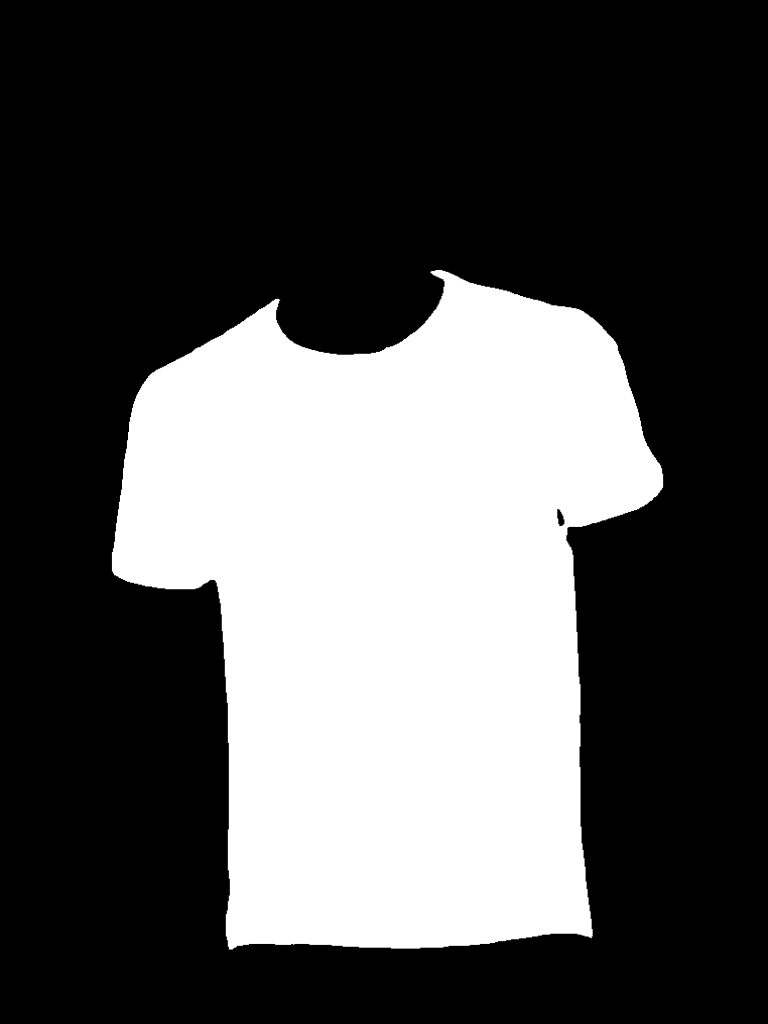

In [4]:
# Visualize the cloth segmentation

from PIL import Image
from IPython.display import display

# Specify the path to the saved image
saved_image_path = '/home/ubuntu/generated/cloth_mask.png'

# Open the saved image using PIL
saved_image = Image.open(saved_image_path)

# Display the image in the Jupyter Notebook cell
display(saved_image)


# Generate Image Parse

In [5]:
import subprocess
import platform 
%cd /home/ubuntu/SOLIDER-HumanParsing

# Run the script
script_path = './test_swin.sh'
subprocess.run(script_path, shell=True, executable='/bin/bash')

/home/ubuntu/SOLIDER-HumanParsing


No pre-trained weights for SwinTransformer, training start from scratch


{'num_classes': 20, 'pretrained': None}
--------------- 0.0 --------------
load pretrained model from None
image mean: [0.485, 0.456, 0.406]
image std: [0.229, 0.224, 0.225]
input space:RGB
RGB Transformation
Total testing sample numbers: 1


  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/sold3/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
100%|██████████| 1/1 [00:09<00:00,  9.85s/it]


CompletedProcess(args='./test_swin.sh', returncode=0)

# Show Image Parse

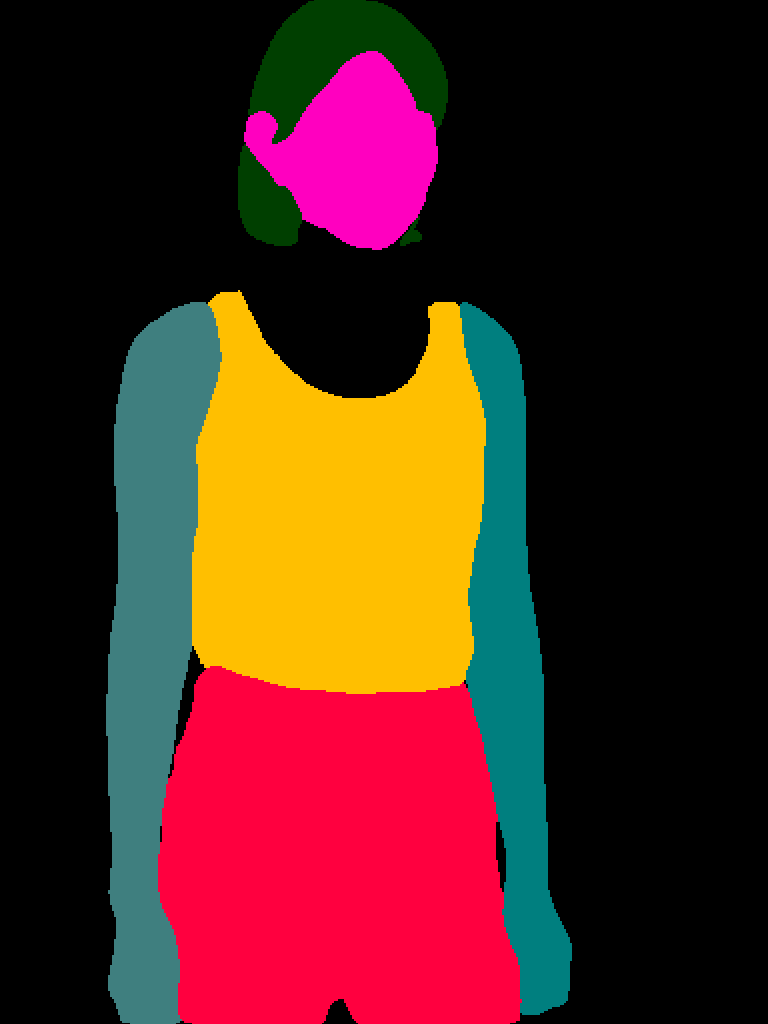

In [6]:
from PIL import Image
from IPython.display import display
import numpy as np
import matplotlib.colors as mcolors

# Specify the path to the saved image
saved_image_path = '/home/ubuntu/generated/person_mask.png'

# Open the saved image using PIL
saved_image = Image.open(saved_image_path)

# Convert the image to a NumPy array for manipulation
image_array = np.array(saved_image)

# Define the provided colormap
colormap = [
    (0, 0, 0),
    (1, 0.25, 0), (0, 0.25, 0), (0.5, 0, 0.25), (1, 1, 1),
    (1, 0.75, 0), (0, 0, 0.5), (0.5, 0.25, 0), (0.75, 0, 0.25),
    (1, 0, 0.25), (0, 0.5, 0), (0.5, 0.5, 0), (0.25, 0, 0.5),
    (1, 0, 0.75), (0, 0.5, 0.5), (0.25, 0.5, 0.5), (1, 0, 0),
    (1, 0.25, 0), (0, 0.75, 0), (0.5, 0.75, 0),
]

# Normalize the colormap values to be in the range [0, 1]
norm_colormap = mcolors.Normalize(vmin=0, vmax=len(colormap)-1)
cmap = mcolors.ListedColormap(colormap)

# Apply the colormap to the image array
colored_image_array = cmap(norm_colormap(image_array))

# Convert the colored image array back to a PIL image
colored_image = Image.fromarray((colored_image_array * 255).astype(np.uint8))

# Display the original and colored images in the Jupyter Notebook cell
display(colored_image)



# Inference VITONHD

In [7]:
%cd /home/ubuntu/work/VITON-HD
!CUDA_VISIBLE_DEVICES=0 python test.py --name res

/home/ubuntu/work/VITON-HD
Namespace(name='res', batch_size=1, workers=1, load_height=1024, load_width=768, shuffle=False, dataset_dir='./datasets/', dataset_mode='test', dataset_list='test_pairs.txt', checkpoint_dir='./checkpoints/', save_dir='./results/', display_freq=1, seg_checkpoint='seg_final.pth', gmm_checkpoint='gmm_final.pth', alias_checkpoint='alias_final.pth', semantic_nc=13, init_type='xavier', init_variance=0.02, grid_size=5, norm_G='spectralaliasinstance', ngf=64, num_upsampling_layers='most')
Network [SegGenerator] was created. Total number of parameters: 34.5 million. To see the architecture, do print(network).
Network [ALIASGenerator] was created. Total number of parameters: 100.5 million. To see the architecture, do print(network).
line /home/ubuntu/images/person.jpeg /home/ubuntu/images/cloth.jpeg

Img name /home/ubuntu/images/person.jpeg
Image name /home/ubuntu/images/person.jpeg
Key unpaired
Image name /home/ubuntu/images/person.jpeg
Key unpaired
Parse Size (768, 1

# Show the generated image

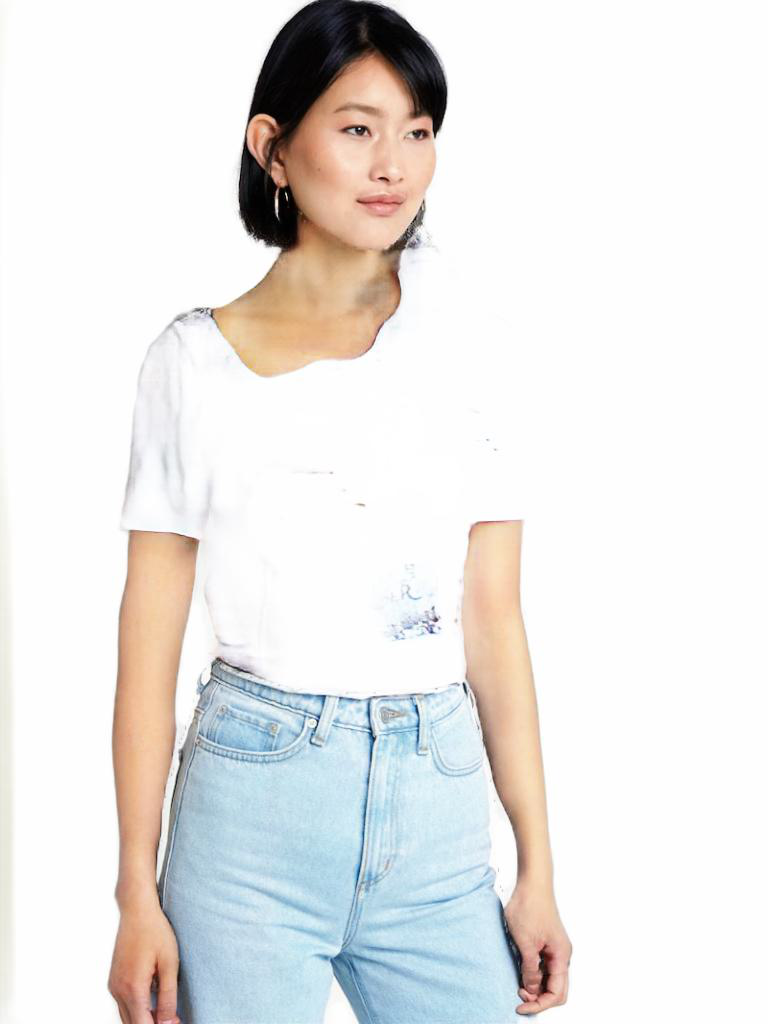

In [8]:
#Show the generated image
# Visualize the cloth segmentation

from PIL import Image
from IPython.display import display

# Specify the path to the saved image
saved_image_path = '/home/ubuntu/generated/vton.jpeg'

# Open the saved image using PIL
saved_image = Image.open(saved_image_path)

# Display the image in the Jupyter Notebook cell
display(saved_image)
